In [15]:
# import sys
# sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

# Importation

In [16]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from utils.vcr import virtual_coil_reconstruction
from utils.data_transform import load_and_transform, create_zero_filled_reconstruction

from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.unet import Unet
from fastmri.data import transforms as T


# Download & Transform

In [17]:
plt.rcParams['figure.figsize'] = (13, 13)
# plt.rcParams['image.cmap'] = 'gray'

In [18]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

# Renvoie un Tensor Pytorch 
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

# Renvoie une image Single Coil
image = virtual_coil_reconstruction(images_multicoil)

# Coil = 1 
image = image.unsqueeze(1)

# Kspace of the new image
kspace = torch.fft.fft2(image)

print(kspace_multicoil.shape)
print(images_multicoil.shape)
print(image.shape)
print(kspace.shape)

torch.Size([16, 16, 640, 320])
torch.Size([16, 16, 640, 320])
torch.Size([16, 1, 640, 320])
torch.Size([16, 1, 640, 320])


Show all the batch

In [19]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show image (abs(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(image[i, 0, :,:]))

# # Show image's phase (angle(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(image[i, 0, :,:]))

# # Show kspace (abs(kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(kspace[i, 0, :,:]))


# Mask application

In [20]:
#  Parametres
mask_type = "magic_fraction"
center_fractions = [0.08]
accelerations = [4]

# Function de Mask
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)


# Reajustement shape pour bien avoir un mask en fonction de l'Ordonnée
kspace = kspace.unsqueeze(-1)

# Application
# # Ici on peux faire un mask par batch . A voir.
mask, _ = mask_func(kspace.shape)
masked_kspace = kspace * mask
zero_filled =torch.fft.ifftn(masked_kspace)

# Pour l'entrainement
target = image.abs()
zero_filled = zero_filled.squeeze(-1)
input = np.abs(zero_filled)

print("kspace : ",kspace.shape)
print("mask : ",mask.shape)
print("kspace de zero_filled : ", masked_kspace.shape)
print("zero_filled, ce sera l'input : ", zero_filled.shape)
print("input: ", input.shape)
print("target : ", target.shape)

kspace :  torch.Size([16, 1, 640, 320, 1])
mask :  torch.Size([1, 1, 1, 320, 1])
kspace de zero_filled :  torch.Size([16, 1, 640, 320, 1])
zero_filled, ce sera l'input :  torch.Size([16, 1, 640, 320])
input:  torch.Size([16, 1, 640, 320])
target :  torch.Size([16, 1, 640, 320])


In [21]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace (abs(masked_kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(masked_kspace[i, 0, :,:]))

# # Show zero-filled (abs(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(zero_filled[i, 0, :,:]))

# Show zero-filled's phase(angle(zero_filled))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(zero_filled[i, 0, :,:]))


# U-net model

In [22]:
chans = 32
num_pool_layers = 4
lr = 0.0001

model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []

num_epochs = 2 # test on 200 , from 54 not much change
for epoch in range(num_epochs):
    input = Variable(input)
    target = Variable(target)

    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch+1}/{num_epochs}]')

# Sauvegarder le modèle
torch.save(model.state_dict(), 'fastmri_unet_model.pth')


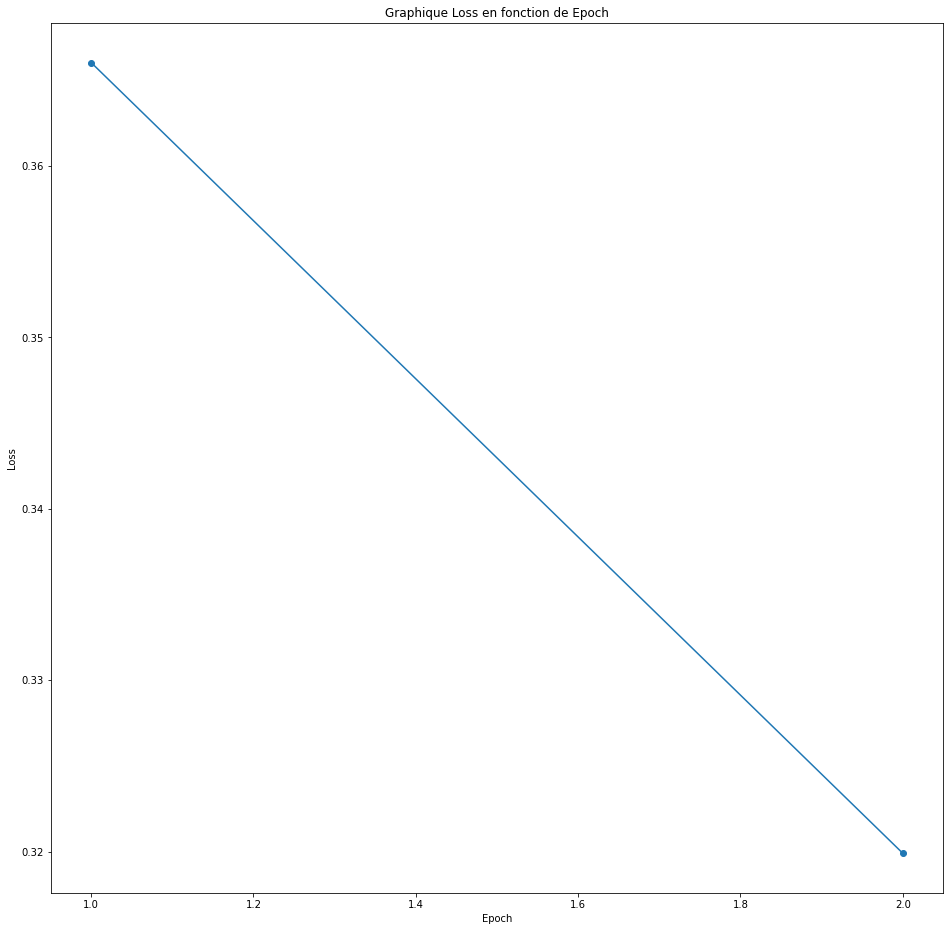

In [23]:
indices = list(range(1, len(loss_list) + 1))

plt.plot(indices, loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphique Loss en fonction de Epoch')
plt.show()


# Test the model


In [26]:
model = Unet(in_chans=1, out_chans=1, chans=chans, num_pool_layers=num_pool_layers)
model.load_state_dict(torch.load('fastmri_unet_model.pth'))

file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))
image = virtual_coil_reconstruction(images_multicoil)
image = image.unsqueeze(1)
kspace = torch.fft.fft2(image)

mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
kspace = kspace.unsqueeze(-1)
mask, _ = mask_func(kspace.shape)
masked_kspace = kspace * mask
zero_filled =torch.fft.ifftn(masked_kspace)
zero_filled = zero_filled.squeeze(-1)
test_image = np.abs(zero_filled)

model.eval()
with torch.no_grad():
    predicted_images = model(test_image)
model.train()

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2

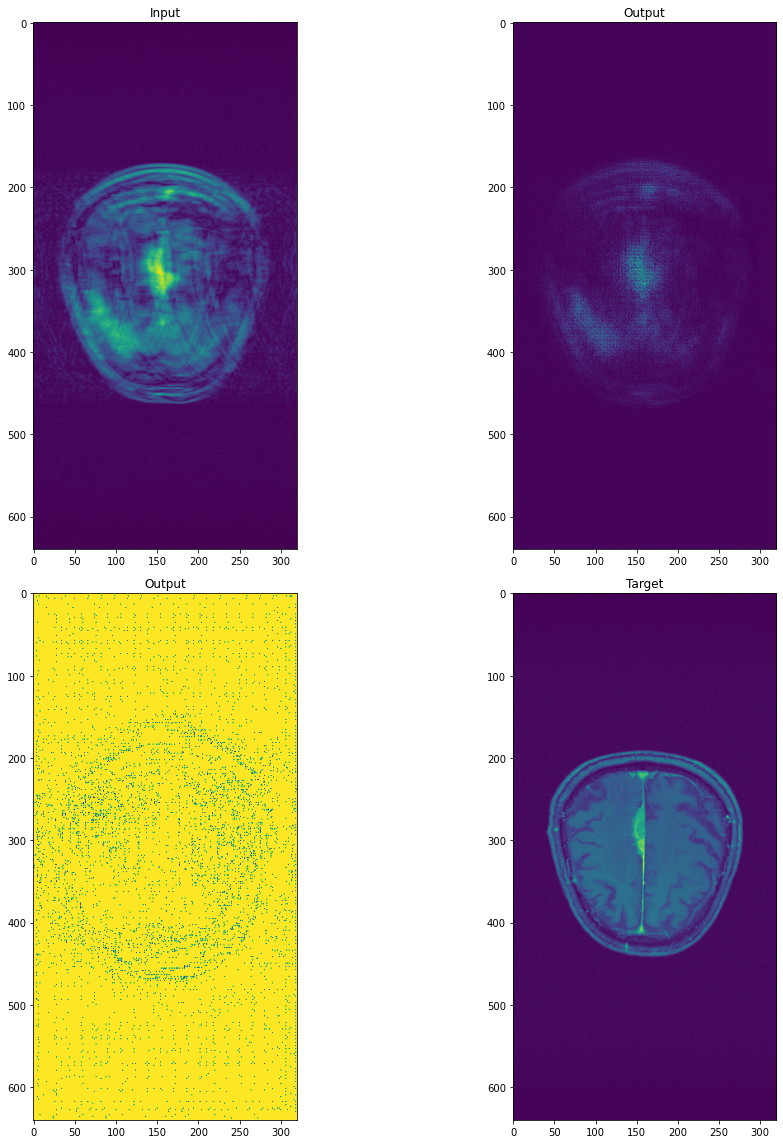

In [38]:
plt.subplot(2,2,1)
plt.imshow(np.abs(test_image[0, 0, :, :]))
plt.title("Input")

plt.subplot(2,2,2)
plt.imshow(np.abs(predicted_images[0,0, :,: ]))
plt.title("Output")

plt.subplot(2,2,3)
plt.imshow(np.angle(predicted_images[0,0, :,: ]))
plt.title("Output phase")

plt.subplot(2,2,4)
plt.imshow(np.abs(image[0, 0, :,: ]))
plt.title("Target")

plt.tight_layout()
plt.show()

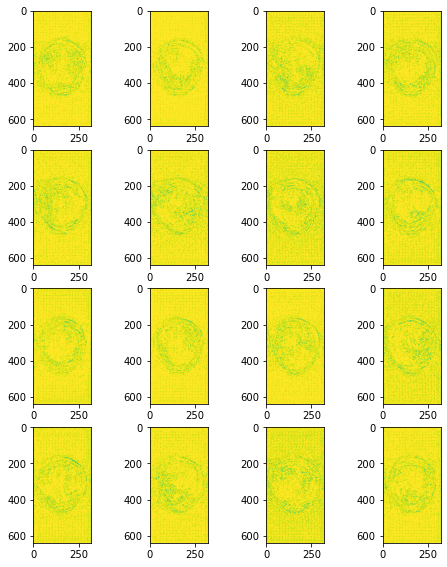

In [34]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace (abs(masked_kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(test_image[i, 0, :,:]))

# # Show zero-filled (abs(zero_filled))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(predicted_images[i, 0, :,:]))

# Show zero-filled's phase(angle(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.angle(predicted_images[i, 0, :,:]))
